In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/Users/arnaud/cellule/data/bnpp2/BNPPjoined.csv")

/Users/arnaud/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (54,55,56,58,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
idx_elec = df["VoiceElec"] == "ELEC"
idx_venue = df["Venue"] == "EBNP"
idx_hasmid = ~np.isnan(df["RFQCompositeMid"])
idx_buy = df["BuySell"].values == "Buy"
df = df[idx_buy & idx_hasmid & idx_venue & idx_elec]

idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"

In [5]:
dd = df[idx_done + idx_traded_away + idx_not_traded]

In [6]:
ratio = abs(dd["BNPPStreamedMid"] - dd["BNPPStreamedQuote"])
data = pd.DataFrame({
        'Y': (dd["BNPPAnsweredQuote"] - dd["RFQCompositeMid"]) / ratio,
        'C1': (dd["CoverPrice"] - dd["RFQCompositeMid"]) / ratio,
        'C2': (dd["CoverPrice2"] - dd["RFQCompositeMid"]) / ratio,
        'C3': (dd["CoverPrice3"] - dd["RFQCompositeMid"]) / ratio,
        'C4': (dd["CoverPrice4"] - dd["RFQCompositeMid"]) / ratio,
        'C5': (dd["CoverPrice5"] - dd["RFQCompositeMid"]) / ratio,
        'I': dd['TradeStatus'],
        'n': dd['NbDealers'] - 1,
        'r': ratio
    })
data['k'] = np.sum(~np.isnan(data[['C1', 'C2', 'C3', 'C4', 'C5']]), axis=1)

In [7]:
idx_Y = (data['Y'] > -3)  & (data['Y'] < 5)
idx_C = ((data['C1'] > -3)  & (data['C1'] < 5)) | np.isnan(data['C1'])
idx_r = data['r'] > 0.1
data = data[idx_Y & idx_C & idx_r]
data = data.reset_index(drop=True)

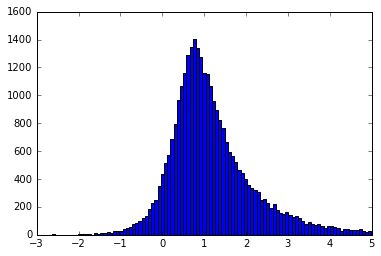

In [8]:
c = 'C1'
plt.hist(data[c][~np.isnan(data[c])].values, bins=100)
plt.show()

In [9]:
train_idx = np.random.choice(data.shape[0] - 1, size=5000, replace=False)
d = data.ix[train_idx, :]

In [10]:
from qmmc.models import ExtendedModel

In [11]:
Y_real = d['Y'].values
k_real = d['k'].values
n_real = d['n'].values
C_real = d[['C1', 'C2', 'C3', 'C4', 'C5']].values
I_real = d['I'].values
model = ExtendedModel(k_real, n_real, Y_real, C_real, I_real)

[ True False False ..., False False False]


In [12]:
model = model.model

In [ ]:
model.estimate(100)

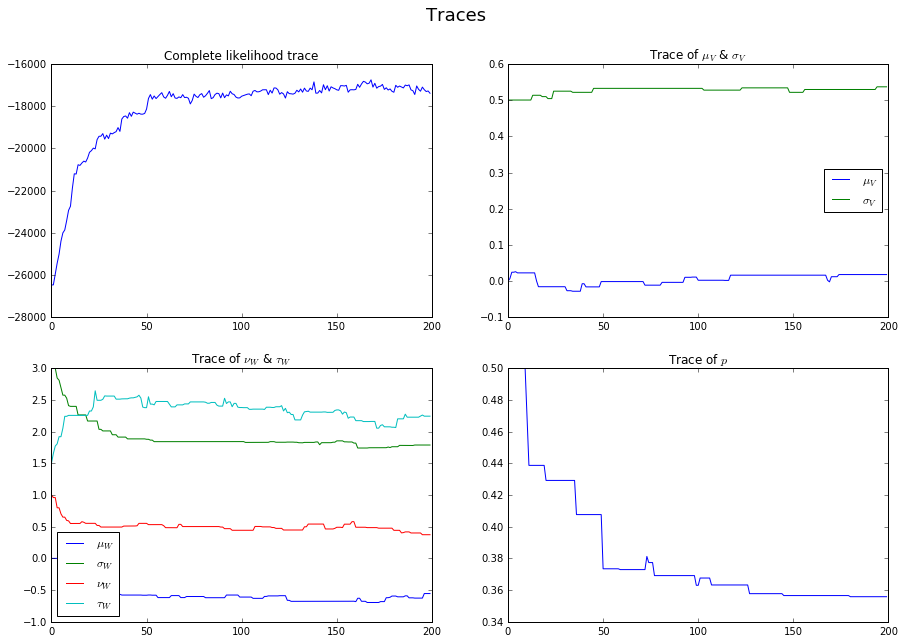

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(model.logp_hist)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
mu_V_trace = model.samplers['mu_V'].get_history()
sigma_V_trace = model.samplers['sigma_V'].get_history()
plt.plot(mu_V_trace)
plt.plot(sigma_V_trace)
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
mu_W_trace = model.samplers['mu_W'].get_history()
sigma_W_trace = model.samplers['sigma_W'].get_history()
nu_W_trace = model.samplers['nu_W'].get_history()
tau_W_trace = model.samplers['tau_W'].get_history()
plt.plot(mu_W_trace)
plt.plot(sigma_W_trace)
plt.plot(nu_W_trace)
plt.plot(tau_W_trace)
plt.legend([r"$\mu_W$", r"$\sigma_W$", r"$\nu_W$", r"$\tau_W$"], loc='best')
plt.title(r"Trace of $\nu_W$ & $\tau_W$")

plt.subplot(2, 2, 4)
p_trace = model.samplers['p'].get_history()
plt.plot(p_trace)
plt.title(r"Trace of $p$")

plt.suptitle(r"Traces", size=18)
plt.show()

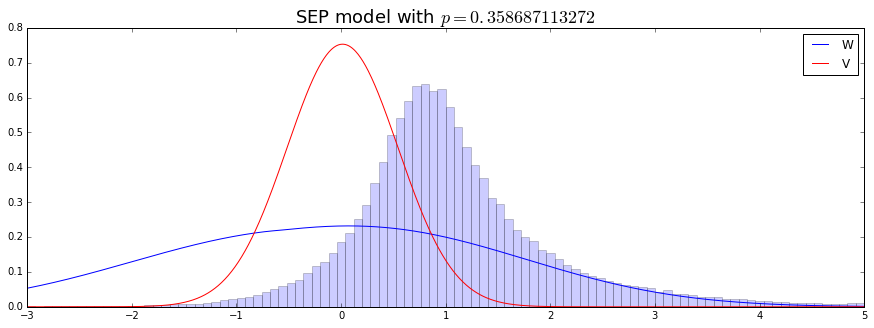

In [19]:
from minipgm.distributions import sep_logpdf
from scipy.stats import norm

n_burn = 100
mu_W_avg = np.mean(mu_W_trace[n_burn:])
sigma_W_avg = np.mean(sigma_W_trace[n_burn:])
nu_W_avg = np.mean(nu_W_trace[n_burn:])
tau_W_avg = np.mean(tau_W_trace[n_burn:])

mu_V_avg = np.mean(mu_V_trace[n_burn:])
sigma_V_avg = np.mean(sigma_V_trace[n_burn:])
p_avg = np.mean(p_trace[n_burn:])

plt.figure(figsize=(15, 5))

xx = np.linspace(-3, 5, 1000)

plt.plot(xx, np.exp(sep_logpdf(xx, mu_W_avg, sigma_W_avg, nu_W_avg, tau_W_avg)), color='b')
plt.plot(xx, norm.pdf(xx, mu_V_avg, sigma_V_avg), color='r')
plt.hist(data['Y'].values, bins=100, normed=True, alpha=0.2)

plt.legend(['W', 'V'])
plt.title(r"SEP model with $p = %s$" % p_avg, size=18)
plt.show()